<a href="https://colab.research.google.com/github/Seung-heon-Baek/KSBi-BIML-2025/blob/main/Copy_of_%5BBIML2025%5DAdvanced_Deep_Learning_Models_for_Biomedical_Research_I_Practice_%E1%84%8C%E1%85%A5%E1%86%BC%E1%84%83%E1%85%A1%E1%86%B8%E1%84%8B%E1%85%AD%E1%86%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BIML 2025 Advanced Deep Learning Models for Biomedical Research I
- 고려대학교 의과대학 전민지 교수, 이지호, 심우종 조교




---




## 실습 목표 1: DNABERT-2 모델 실습 및 Fine-tuning


### 실습 논문
- Zhihan Zhou, Yanrong Ji, Weijian Li, Pratik Dutta, Ramana Davuluri, and Han Liu. 2023. Dnabert-2: Efficient foundation model and benchmark for multi-species genome. arXiv preprint:2306.15006(2023)

### 실습 과정
1. 패키지 불러오기
2. DNABERT-2 불러오기
3. DNABERT-2 임베딩 추출하기
4. 생성한 임베딩으로 classification하기
5. DNABERT-2 fine-tuning하기




---




## 실습 목표 2: ESM-2 모델 실습 및 Downstream analysis


### 실습 논문
- Lin, Zeming, et al. "Evolutionary-scale prediction of atomic level protein structure with a language model." bioRxiv (2022): 2022-07.

### 실습 과정
1. 패키지 불러오기
2. ESM-2 불러오기
3. 시퀀스 데이터 불러오기
4. ESM-2 임베딩 추출하기
5. ESM-2 임베딩 시각화하기
6. UniProt에서 단백질 시퀀스를 불러와 임베딩 추출, 시각화하기

#0. 실습을 위한 안내

**먼저, 실습에 사용할 dataset을 다운로드해야합니다.**

https://drive.google.com/file/d/1z93f7aji1iKmn3i7W1CAVGnbONwdq34O/view?usp=sharing

위 링크에서 data.zip을 다운받아 **내 드라이브 (MyDrive)**에 옮겨 주세요.


실습 과정에 여러분이 직접 코드를 작성해야하는 부분이 포함되어 있습니다.

<font color='45A07A'>## 코드를 직접 작성해주세요 ##</font> 라고 표시된 부분을 채워서 코드를 완성해주세요.

## 0-1. Colab 사용자를 위한 안내

**로컬(개인 노트북)이 아닌 Colab 환경에서 실행하고자 하시는 분을 위한 안내입니다.**

**로컬에서 실행하실 분은 "로컬 사용자를 위한 안내"로 넘어가세요.**

**먼저 GPU를 사용하기 위한 설정입니다.**

`T4 RAM 디스크` 아이콘 옆의 `추가 연결 옵션` -> `런타임 유형 변경` -> 하드웨어 가속기를 `T4 GPU` 로 설정 후 저장

**이제 구글 드라이브와 Colab을 연결합니다.**

In [ ]:
## Google Drive mount

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


다운 받은 `data.zip` 파일을 압축 해제하여 현재 경로에 두겠습니다.

먼저 data 폴더 안에 **DNABERT2와 ESM2 실습 용 데이터**가 모두 들어있는지 확인해주세요.

In [ ]:
import subprocess

# Google Drive 내 data.zip 파일의 절대 경로를 지정
target_file_path = "/content/drive/MyDrive/data.zip"

# data.zip 파일을 현재 위치에 압축 해제
command = ["unzip", "-qq", target_file_path, "-d", "./"]
subprocess.run(command)

CompletedProcess(args=['unzip', '-qq', '/content/drive/MyDrive/data.zip', '-d', './'], returncode=0)

## 0-2. 로컬 사용자를 위한 안내

**Colab이 아닌 로컬(개인 노트북)에서 실행하고자 하시는 분을 위한 안내입니다.**

**로컬 사용자**

다운로드한 파일의 압축을 풀어주세요.

프로젝트 디렉토리에 **DNABERT2 폴더와 ESM2 폴더**가 모두 있는지 확인해주세요.

# 실습 1. DNABERT-2 모델 실습 및 Fine-tuning

##1. 패키지 불러오기

In [ ]:
import os
import json
import glob
import subprocess

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import transformers
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForMaskedLM
from transformers.models.bert.configuration_bert import BertConfig

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

- `os` : 파일 및 폴더 관리, 환경 변수 설정과 같은 운영체제 기능을 조작하기 위해 사용합니다.
- `json` : JSON 파일을 읽고 쓰거나, 데이터 변환을 위해 사용합니다.
- `glob` : 파일 및 디렉토리를 검색하기 위해 사용합니다.
- `subprocess` : 터미널이나 CMD 시스템 명령을 실행하기 위해 사용합니다.

- `numpy` :  Scientific computing과 관련된 여러 편리한 기능들을 제공해주는 라이브러리입니다.
- `pandas` :  데이터를 load하기 위해 사용합니다.
- `torch` : Pytorch 라이브러리로, 딥러닝 모델을 구현하고 학습하는 데 사용됩니다.
- `torch.nn` : 모델의 각 Layer들을 만들기 위해 사용합니다.
- `torch.optim` : pytorch를 최적화하는 모듈로, 다양한 optimizer를 제공합니다.

- `transformers` : Hugging Face 라이브러리로, 사전 학습된 Transformer 모델을 불러오고 활용하는 데 사용합니다.


- `sklearn` : 머신러닝 라이브러리로 데이터 분할과 모델 성능 평가를 위해 사용합니다.

In [ ]:
## Seed를 고정합니다.
torch.manual_seed(1)
np.random.seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print('GPU 사용 가능 여부: {}'.format(use_cuda))

GPU 사용 가능 여부: True


**GPU 사용 가능 여부가 False로 뜨시는 분은 런타임을 확인해주세요.**

`T4 RAM 디스크` 아이콘 옆의 `추가 연결 옵션` -> `런타임 유형 변경` -> 하드웨어 가속기를 `T4 GPU` 로 설정 후 저장

## 2. DNABERT-2 불러오기

Hugging Face 모델 허브에서 DNABERT-2 관련 리소스를 가져오는 단계입니다.

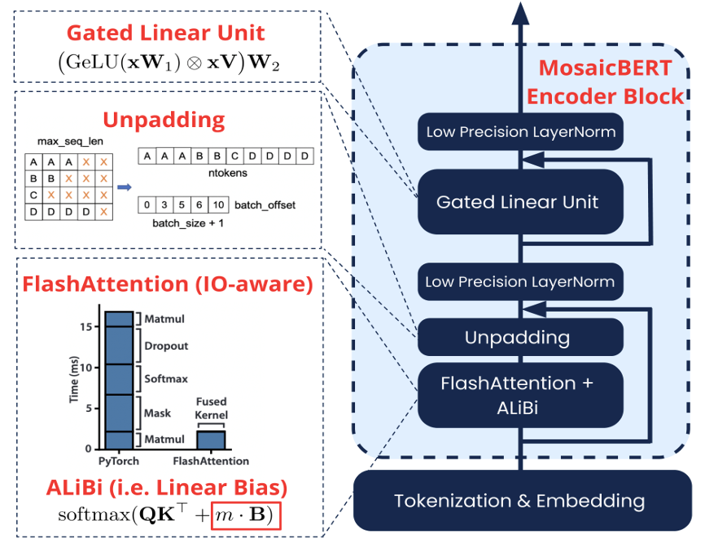

BertConfig와 AutoTokenizer를 사용하여 DNABERT-2-117M 모델의 config와 tokenizer를 불러오겠습니다.

(DNABERT-2 뒤에 붙은 117M은 파라미터 수를 뜻합니다.)

- `BertConfig` : BERT 모델의 설정을 정의하는 클래스입니다. 모델의 hidden 크기, head 개수, layer 개수 등의 하이퍼파라미터를 저장합니다.
- `Autotokenizer` : Hugging Face transformers 라이브러리에서 제공하는 자동 tokenizer 클래스입니다.


In [ ]:
config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/158 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/168k [00:00<?, ?B/s]

bert_layers.py:   0%|          | 0.00/40.7k [00:00<?, ?B/s]

flash_attn_triton.py:   0%|          | 0.00/42.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNABERT-2-117M:
- flash_attn_triton.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


bert_padding.py:   0%|          | 0.00/6.10k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNABERT-2-117M:
- bert_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNABERT-2-117M:
- bert_layers.py
- flash_attn_triton.py
- bert_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/468M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- `config` : 사전 학습된 `DNABERT-2-117M` 모델의 설정을 로드합니다. ("zhihan1996/DNABERT-2-117M"은 모델의 Hugging Face 저장 경로입니다.)
- `tokenizer` : `AutoTokenizer`를 사용하여 해당 모델에 맞는 tokenizer를 불러옵니다. 여기서는 DNA 서열을 토큰화 하는 데 사용됩니다.

In [ ]:
config.attention_probs_dropout_prob=1e-6
config

BertConfig {
  "_name_or_path": "zhihan1996/DNABERT-2-117M",
  "alibi_starting_size": 512,
  "attention_probs_dropout_prob": 1e-06,
  "auto_map": {
    "AutoConfig": "zhihan1996/DNABERT-2-117M--configuration_bert.BertConfig",
    "AutoModel": "zhihan1996/DNABERT-2-117M--bert_layers.BertModel",
    "AutoModelForMaskedLM": "zhihan1996/DNABERT-2-117M--bert_layers.BertForMaskedLM",
    "AutoModelForSequenceClassification": "zhihan1996/DNABERT-2-117M--bert_layers.BertForSequenceClassification"
  },
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.48.3",
  "type_vocab_size": 2,
  "use_cach

- `alibi_starting_size` : DNABERT-2에서 사용하는 ALiBi (Attention with Linear Biases) 기능의 초기 크기를 설정하는 파라미터입니다. 기본적으로 512로 설정이 되어있고, 이후에는 입력 token의 길이를 기준으로 ALiBi mask를 확장합니다.
- `attention_probs_dropout_prob` : 어텐션 드롭아웃 비율을 설정하는 파라미터입니다.
- `auto_map` : auto_map의 항목들은 자동 모델 매핑을 위한 것입니다. 해당 구성을 기반으로 적절한 모델을 로드하는 데 사용합니다.
- `classifier_dropout` : classifier 레이어에서 드롭아웃 비율을 설정하는 파라미터입니다.
- `gradient_checkpointing` : 그라디언트를 저장할지 설정하는 파라미터입니다.
- `hidden_act` : 활성화 함수를 설정하는 파라미터입니다.
- `hidden_dropout_prob` : 히든 레이어의 드롭아웃 비율을 설정합니다.
- `hidden_size` : 히든 레이어의 크기를 설정합니다. BERT-base의 모델에서는 768이 일반적입니다.
- `initializer_range` : 모델 파라미터를 초기화할 때 사용되는 범위를 설정합니다.
- `intermediate_size` : 중간 layer인 Feedforward network의 크기를 설정합니다.
- `layer_norm_eps` : Layer normalization의 epsilon 값을 설정합니다.
- `max_postiion_embeddings` : 모델에서 처리할 수 있는 최대 시퀀스 길이를 설정합니다. 이는 ALiBi가 없을 때의 위치 임베딩의 크기입니다.
- `model_type` : 모델의 종류를 설정합니다.
- `num_attention_heads` : 어텐션 헤드의 개수를 설정합니다.
- `num_hidden_layers` : 히든 레이어의 개수를 설정합니다.
- `pad_token_id` : 패딩 token의 ID를 설정합니다.
- `position_embedding_type` : 위치 임베딩의 종류를 설정합니다. BERT에서는 절대 위치 임베딩을 사용하지만, ALiBi의 위치 임베딩은 이와 다릅니다.
- `torch_dtype` : 데이터 타입을 설정합니다.
- `transformers_version` : 이 모델이 Hugging Face Transformers 라이브러리의 버전 4.48.3에서 사용되는 구성임을 나타냅니다.
- `type_vocab_size` : vocabulary의 크기를 설정합니다.
- `use_cahce` : 캐시를 사용할지 여부를 설정합니다.
- `vocab_size` : 모델이 사용하는 vocabulary의 크기를 설정합니다. DNABERT-2에서는 4096개의 고유 token을 사용하여 DNA 서열을 표현합니다.

In [ ]:
tokenizer

PreTrainedTokenizerFast(name_or_path='zhihan1996/DNABERT-2-117M', vocab_size=4096, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

- `vocab_size` : DNA 시퀀스를 특정 사이즈로 분할한 unique 토큰으로 구성된 vocabulary의 크기입니다.
- `model_max_length` : 입력 시퀀스 길이의 제한입니다. DNABERT-2 모델은 ALiBi를 사용하기 때문에 이 제한이 적용되지 않습니다.
- `padding_side` : 시퀀스의 길이가 부족할 경우, 오른쪽에 패딩을 추가합니다.
- `truncation_side` : 시퀀스의 길이가 최대 모델 길이를 초과할 경우, 오른쪽에서 잘립니다.
- `special_tokens`
  - [UNK] : 알 수 없는 토큰
  - [SEP] : 시퀀스 분리 토큰
  - [PAD] : 패딩 토큰
  - [CLS] : 시퀀스 분류를 위한 시작 토큰
  - [MASK] : 마스킹 토큰

이제 `AutoModel`을 사용하여 DNABERT-2 모델을 불러오겠습니다. 이 때, 이전에 설정한 config를 모델에 적용합니다.
- `AutoModel` : Hugging Face `transformers` 라이브러리에서 제공하는 자동 모델 로더입니다.

In [ ]:
model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config)

Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model=model.to(device)
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(4096, 768, padding_idx=0)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertUnpadAttention(
          (self): BertUnpadSelfAttention(
            (dropout): Dropout(p=1e-06, inplace=False)
            (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (mlp): BertGatedLinearUnitMLP(
          (gated_layers): Linear(in_features=768, out_features=6144, bias=False)
          (act): GELU(approximate='none')


DNABERT-2는 BERT 기반의 transformer 모델로 embeddings, encoder, pooler 구성 요소로 이루어져 있습니다.

- embeddings : 입력 데이터를 임베딩 벡터로 변환합니다.
- encoder : multi-head attention과 feedforward network가 포함되어 있습니다.
- pooler : [CLS] 토큰의 임베딩을 사용해 문장 수준의 output을 생성합니다. 이 때, pooler는 사전 학습이 되어있지 않습니다.

## 3. DNABERT-2 임베딩 추출하기

이제 DNABERT-2 모델을 사용하여 DNA 서열을 입력으로 받아 임베딩을 추출하겠습니다.

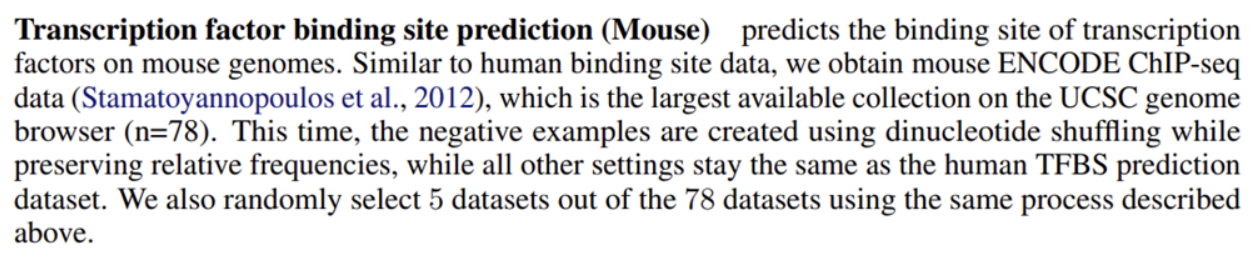

사용할 데이터는 마우스 유전체에서 전사인자 결합 부위(Transcription Factor Binding Site, TFBS)를 예측하기 위한 데이터셋입니다.

이 데이터셋에는 Binding(결합)과 Non-Binding(비결합) 두 가지 유형의 샘플이 포함되어 있습니다.

먼저, TFBS 학습 데이터셋을 불러와 구조와 내용을 확인해 보겠습니다.

In [ ]:
TF_binding = pd.read_csv('./data/DNABERT2/TF_binding.csv')
TF_binding.head()

,sequence,label
0,TGTGGGAGGTAGAGAGCGCCTGTGCCCGGCCGCCCCGTCTGGGAAG...,0
1,CTAGTTAGCTAAGGGATTCTTAAAGGGAAAGCTCTGAAGTCTGAAG...,1
2,GCTGCACGTGCTCGGGGGGCCCGTGCCTGCCCCTCAGCTTTGCCCC...,0
3,GGCCGCCTTGCCTCCGCCGCCATCAAGGGCGACTTTGGAAACAGAC...,1
4,GAGACGCTCCTCACTTCCCAGACGGGGTGGCGGCCGGGCGGAGGCT...,0


In [ ]:
print("Transcription Factor binding prediction 데이터의 형태")
print(TF_binding.shape)
print("시퀀스의 길이")
print(TF_binding['sequence'].apply(len).iloc[0])
print("라벨의 종류")
print(TF_binding['label'].unique())

Transcription Factor binding prediction 데이터의 형태
(9713, 2)
시퀀스의 길이
101
라벨의 종류
[0 1]


위의 출력 결과와 같이 샘플의 개수는 9713개이고, 시퀀스의 길이는 101bp, 라벨은 0과 1임을 확인할 수 있습니다.

이제 DNABERT-2 모델을 사용하여 입력된 DNA 시퀀스에 대한 임베딩을 얻어보겠습니다.

DNABERT-2는 입력된 서열의 각 token에 대한 임베딩을 생성합니다.

모델의 마지막 레이어에서 hidden state를 가져와 token 별 임베딩을 추출할 수 있습니다.

이후, 서열 전체를 하나의 벡터로 표현하기 위해 pooling을 적용합니다.
- `embedding_mean` : 모든 token의 평균값을 가져옴
- `embedding_max` : 각 차원별 최댓값을 가져옴

In [ ]:
def get_embeddings(sequence, model, tokenizer, device):
    # 서열 토큰화
    tokens = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    tokens = {key: val.to(device) for key, val in tokens.items()}

    # 모델 추론
    with torch.no_grad():
        outputs = model(**tokens)
    hidden_states = outputs[0]  # 마지막 레이어의 Hidden States

    # Mean Pooling (평균 임베딩)
    embedding_mean = torch.mean(hidden_states[0], dim=0)

    # Max Pooling (최대값 임베딩)
    embedding_max = torch.max(hidden_states[0], dim=0)[0]

    return embedding_mean, embedding_max

In [ ]:
# 모든 서열의 임베딩 저장
mean_embeddings = []
max_embeddings = []

for seq in TF_binding['sequence']:
    mean_emb, max_emb = get_embeddings(seq, model, tokenizer, device)
    mean_embeddings.append(mean_emb.cpu().numpy())
    max_embeddings.append(max_emb.cpu().numpy())

model.safetensors:   0%|          | 0.00/468M [00:00<?, ?B/s]

In [ ]:
mean_emb

tensor([ 3.2528e-02,  8.5357e-02,  1.2293e-02, -4.4927e-02, -1.2922e-01,
        -2.8904e-02, -1.0980e-02, -1.0278e-01,  2.2757e-02,  3.3390e-02,
        -8.6982e-02,  1.9305e-02,  2.3030e-02, -9.1952e-02, -4.9721e-02,
        -3.0522e-02, -3.1896e-02,  4.2344e-02,  3.4260e-02, -1.8045e-01,
         9.8549e-02,  8.9742e-02, -3.8299e-02, -2.9654e-02,  3.2699e-02,
         4.2729e-02,  2.8850e-01,  4.7555e-02, -9.1376e-02, -4.8900e-02,
        -1.6073e-03,  8.7969e-02, -6.0640e-02, -1.8230e-02, -2.0635e-01,
         3.1293e-02, -8.1191e-02, -5.4647e-02,  6.0380e-02, -5.6103e-02,
        -1.0927e-01,  6.2868e-02,  6.1067e-02, -4.4444e-02, -4.0837e-03,
         8.5328e-03, -1.5011e-01, -4.2890e-02, -7.2031e-02,  4.2904e-02,
         4.9420e-03, -8.2584e-02, -1.0395e-01,  8.3224e-02, -2.6090e-02,
         7.6409e-02,  1.2430e-01, -8.4521e-02, -1.6651e-01,  3.1103e-03,
         1.1033e-03,  2.8360e-03, -9.0995e-03, -1.2853e-01,  5.2422e-02,
         2.5072e-02, -1.2838e-01, -7.2453e-02, -5.4

In [ ]:
mean_emb.shape

torch.Size([768])

위와 같이 pooling을 통해 각 서열 당 하나의 임베딩을 추출할 수 있습니다.

In [ ]:
mean_embeddings_array = np.array(mean_embeddings)
print(mean_embeddings_array.shape)

(9713, 768)


In [ ]:
# 임베딩 결과를 데이터프레임으로 저장
TF_binding['embedding_mean'] = mean_embeddings
TF_binding['embedding_max'] = max_embeddings

In [ ]:
TF_binding.head()

,sequence,label,embedding_mean,embedding_max
0,TGTGGGAGGTAGAGAGCGCCTGTGCCCGGCCGCCCCGTCTGGGAAG...,0,"[-0.15591638, 0.09802514, 0.038276985, -0.0795...","[0.13753697, 0.32841635, 0.3736371, 0.311313, ..."
1,CTAGTTAGCTAAGGGATTCTTAAAGGGAAAGCTCTGAAGTCTGAAG...,1,"[0.109410495, -0.11533982, 0.01145565, -0.1480...","[0.27854848, 0.051550485, 0.16549258, 0.015709..."
2,GCTGCACGTGCTCGGGGGGCCCGTGCCTGCCCCTCAGCTTTGCCCC...,0,"[-0.09487176, 0.017754674, 0.13721643, -0.0863...","[0.21256223, 0.23278359, 0.38373083, 0.1811795..."
3,GGCCGCCTTGCCTCCGCCGCCATCAAGGGCGACTTTGGAAACAGAC...,1,"[-0.10856312, 0.12251826, 0.17625675, -0.10100...","[0.1577694, 0.3360213, 0.48321587, 0.23157404,..."
4,GAGACGCTCCTCACTTCCCAGACGGGGTGGCGGCCGGGCGGAGGCT...,0,"[-0.09126808, 0.02390439, 0.052555066, -0.1466...","[0.25801212, 0.53979284, 0.39271313, 0.0151971..."


이렇게 예시 시퀀스 데이터에 대한 임베딩을 얻었습니다.

위의 출력된 결과를 통해 개의 각 9713개의 서열마다 768dim 임베딩이 하나 씩 생성되었음을 확인할 수 있습니다.

## 4. 생성한 임베딩으로 classification하기

주어진 DNA 서열 데이터를 이용해 다층 퍼셉트론 (MLP, Multi-Layer Perceptron) 기반의 분류 모델을 훈련해보겠습니다.

모델의 입력은 DNABERT-2를 통해 얻은 서열의 임베딩 벡터이며, 출력은 각 서열이 속하는 클래스(라벨)입니다.

In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.fc4(x)
        return x

이 MLP 모델은 주어진 768차원의 입력 데이터를 받아, 세 개의 linear layer와 ReLU 활성화 함수를 거쳐 최종 출력을 생성합니다.

mean pooling을 통해 만든 시퀀스 단위 임베딩, `embedding_mean`을 사용하여 먼저 학습을 해보겠습니다.

In [ ]:
# 데이터 분리
X = torch.tensor(TF_binding['embedding_mean'].tolist(), dtype=torch.float32)
y = torch.tensor(TF_binding['label'].values, dtype=torch.long)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<ipython-input-20-2ba2ad1e55cb>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(TF_binding['embedding_mean'].tolist(), dtype=torch.float32)


train_test_split()을 사용하여 서열 데이터의 80%는 학습용, 20%는 테스트용으로 나누었습니다.

In [ ]:
# 하이퍼파라미터 설정
input_size = 768
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
num_classes = 2
num_epochs = 100
learning_rate = 0.0001

# 모델 초기화
MLP_model = MLPClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP_model.parameters(), lr=learning_rate)

MLP 모델 학습을 위해 하이퍼파라미터 설정 및 초기화를 하였습니다.

In [ ]:
# 학습 루프
for epoch in range(num_epochs):
    MLP_model.train()
    inputs = X_train.to(device)
    labels = y_train.to(device)

    # Forward
    outputs = MLP_model(inputs)
    loss = criterion(outputs, labels)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.6941
Epoch [2/100], Loss: 0.6938
Epoch [3/100], Loss: 0.6935
Epoch [4/100], Loss: 0.6932
Epoch [5/100], Loss: 0.6929
Epoch [6/100], Loss: 0.6926
Epoch [7/100], Loss: 0.6923
Epoch [8/100], Loss: 0.6920
Epoch [9/100], Loss: 0.6917
Epoch [10/100], Loss: 0.6914
Epoch [11/100], Loss: 0.6910
Epoch [12/100], Loss: 0.6907
Epoch [13/100], Loss: 0.6903
Epoch [14/100], Loss: 0.6899
Epoch [15/100], Loss: 0.6894
Epoch [16/100], Loss: 0.6889
Epoch [17/100], Loss: 0.6884
Epoch [18/100], Loss: 0.6878
Epoch [19/100], Loss: 0.6872
Epoch [20/100], Loss: 0.6866
Epoch [21/100], Loss: 0.6859
Epoch [22/100], Loss: 0.6851
Epoch [23/100], Loss: 0.6842
Epoch [24/100], Loss: 0.6833
Epoch [25/100], Loss: 0.6823
Epoch [26/100], Loss: 0.6813
Epoch [27/100], Loss: 0.6801
Epoch [28/100], Loss: 0.6789
Epoch [29/100], Loss: 0.6776
Epoch [30/100], Loss: 0.6762
Epoch [31/100], Loss: 0.6747
Epoch [32/100], Loss: 0.6731
Epoch [33/100], Loss: 0.6714
Epoch [34/100], Loss: 0.6696
Epoch [35/100], Loss: 0

MLP 모델은 총 100 epoch 동안 데이터를 학습하며 loss를 최소화하는 방향으로 업데이트됩니다.

In [ ]:
# 모델 평가
MLP_model.eval()
with torch.no_grad():
    inputs = X_test.to(device)
    labels = y_test.to(device)
    outputs = MLP_model(inputs)
    _, predicted = torch.max(outputs, 1)

# 정확도 계산
accuracy = accuracy_score(labels.cpu(), predicted.cpu())
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7638


이렇게 모델의 최종 예측 성능까지 보았습니다.

이제 이 과정을 `max_embedding`을 사용해서도 진행하겠습니다.

In [ ]:
# 데이터 분리
X = torch.tensor(TF_binding['embedding_max'].tolist(), dtype=torch.float32)
y = torch.tensor(TF_binding['label'].values, dtype=torch.long)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

아래의 모델 하이퍼파라미터를 자유롭게 조정하여 모델 학습을 해보세요.

In [ ]:
# 하이퍼파라미터 설정
input_size = 768
hidden_size1 = 512
hidden_size2 = 256
hidden_size3 = 128
num_classes = 2
num_epochs = 100
learning_rate = 0.0001

# 모델 초기화
MLP_model = MLPClassifier(input_size, hidden_size1, hidden_size2, hidden_size3, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP_model.parameters(), lr=learning_rate)

In [ ]:
# 학습 루프
for epoch in range(num_epochs):
    MLP_model.train()
    inputs = X_train.to(device)
    labels = y_train.to(device)

    # Forward
    outputs = MLP_model(inputs)
    loss = criterion(outputs, labels)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.6932
Epoch [2/100], Loss: 0.6928
Epoch [3/100], Loss: 0.6924
Epoch [4/100], Loss: 0.6921
Epoch [5/100], Loss: 0.6918
Epoch [6/100], Loss: 0.6914
Epoch [7/100], Loss: 0.6911
Epoch [8/100], Loss: 0.6908
Epoch [9/100], Loss: 0.6904
Epoch [10/100], Loss: 0.6900
Epoch [11/100], Loss: 0.6896
Epoch [12/100], Loss: 0.6892
Epoch [13/100], Loss: 0.6887
Epoch [14/100], Loss: 0.6881
Epoch [15/100], Loss: 0.6876
Epoch [16/100], Loss: 0.6869
Epoch [17/100], Loss: 0.6862
Epoch [18/100], Loss: 0.6855
Epoch [19/100], Loss: 0.6848
Epoch [20/100], Loss: 0.6840
Epoch [21/100], Loss: 0.6831
Epoch [22/100], Loss: 0.6822
Epoch [23/100], Loss: 0.6811
Epoch [24/100], Loss: 0.6800
Epoch [25/100], Loss: 0.6788
Epoch [26/100], Loss: 0.6775
Epoch [27/100], Loss: 0.6762
Epoch [28/100], Loss: 0.6747
Epoch [29/100], Loss: 0.6732
Epoch [30/100], Loss: 0.6716
Epoch [31/100], Loss: 0.6699
Epoch [32/100], Loss: 0.6680
Epoch [33/100], Loss: 0.6659
Epoch [34/100], Loss: 0.6638
Epoch [35/100], Loss: 0

In [ ]:
# 모델 평가
MLP_model.eval()
with torch.no_grad():
    inputs = X_test.to(device)
    labels = y_test.to(device)
    outputs = MLP_model(inputs)
    _, predicted = torch.max(outputs, 1)

# 정확도 계산
accuracy = accuracy_score(labels.cpu(), predicted.cpu())
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7226


위의 mean pooling 임베딩을 사용했을 때와 max pooling 임베딩을 사용했을 때의 성능을 비교해보세요!

## 5. DNABERT-2 fine-tuning하기

DNABERT-2 모델을 우리가 보유한 데이터셋에 맞춰 fine-tuning 하여 최적화할 수 있습니다.

아래와 같은 데이터를 활용해 DNABERT-2의 fine-tuning 과정을 진행해보겠습니다.

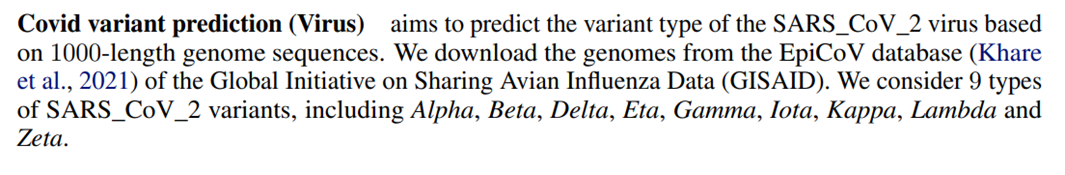

사용할 데이터는 SARS-CoV-2 변이 유형을 예측하기 위한 데이터셋입니다.

해당 데이터에는 Alpha, Beta, Delta, Eta, Gamma, Iota, Kappa, Lambda, Zeta 의 9가지 변이 유형이 포함되어 있습니다.

먼저, covid 데이터셋을 불러와 구조와 내용을 확인해 보겠습니다

In [ ]:
covid_train = pd.read_csv('./data/DNABERT2/covid/train.csv')
covid_train.head()

,sequence,label
0,AGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACC...,3
1,ATGTTTTTATGTCTGAAGCAAAATGTTGGACTGAGACTGACCTTAC...,1
2,CTGAGAAGTCTAACATAATAAGAGGCTGGATTTTTGGTACTACTTT...,6
3,TATTTAAACACATTAACATTAGCTGTACCCTATAATATGAGAGTTA...,0
4,TCATTATTAGTGATATGTACGACCCTAAGACTAAAAATGTTACAAA...,2


In [ ]:
print("covid 학습 데이터셋의 형태")
print(covid_train.shape)
print("시퀀스의 길이")
print(covid_train['sequence'].apply(len).iloc[0])
print("라벨의 종류")
print(covid_train['label'].unique())

covid 학습 데이터셋의 형태
(2200, 2)
시퀀스의 길이
999
라벨의 종류
[3 1 6 0 2 7 8 4 5]


위의 출력 결과와 같이 훈련 샘플의 개수는 2200개이고, 시퀀스의 길이는 999bp, 라벨은 9개임을 확인할 수 있습니다.

마찬가지로 test와 development 데이터셋도 불러와서 확인해보겠습니다.

In [ ]:
covid_test = pd.read_csv('./data/DNABERT2/covid/test.csv')

print("covid 테스트 데이터셋의 형태")
print(covid_test.shape)
print("시퀀스의 길이")
print(covid_test['sequence'].apply(len).iloc[0])
print("라벨의 종류")
print(covid_test['label'].unique())

covid 테스트 데이터셋의 형태
(275, 2)
시퀀스의 길이
999
라벨의 종류
[1 7 2 0 5 6 4 3 8]


In [ ]:
covid_dev = pd.read_csv('./data/DNABERT2/covid/dev.csv')

print("covid 개발 데이터셋의 형태")
print(covid_dev.shape)
print("시퀀스의 길이")
print(covid_dev['sequence'].apply(len).iloc[0])
print("라벨의 종류")
print(covid_dev['label'].unique())

covid 개발 데이터셋의 형태
(275, 2)
시퀀스의 길이
999
라벨의 종류
[8 2 6 1 5 7 0 4 3]


covid 데이터셋 중에서 하나의 데이터에 대한 DNABERT-2 임베딩을 추출해보겠습니다.

우선 아래 임베딩 추출 함수의 빈칸을 채워주세요.

In [ ]:
def get_embeddings(sequence, model, tokenizer, device):
    # 서열 토큰화
    tokens = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True, max_length=512)
    tokens = {key: val.to(device) for key, val in tokens.items()}

    # 모델 추론
    with torch.no_grad():
        outputs = model(**tokens)
    hidden_states = outputs[0]  # 힌트 : 마지막 레이어의 Hidden States

    # Mean Pooling (평균 임베딩)
    embedding_mean = torch.mean(hidden_states[0], dim=0)

    # Max Pooling (최대값 임베딩)
    embedding_max = torch.max(hidden_states[0], dim=0)[0]

    return embedding_mean, embedding_max

완성한 함수를 바탕으로 임베딩을 추출하겠습니다.

In [ ]:
# covid 데이터셋의 첫 번째 서열 가져오기
first_sequence = covid_train.iloc[0]["sequence"]
first_sequence

'AGCAATCTTTTGTTGCAATATGGCAGTTTTTGTACACAATTAAACCGTGCTTTAACTGGAATAGCTGTTGAACAAGACAAAAACACCCAAGAAGTTTTTGCACAAGTCAAACAAATTTACAAAACACCACCAATTAAAGATTTTGGTGGTTTTAATTTTTCACAAATATTACCAGATCCATCAAAACCAAGCAAGAGGTCATTTATTGAAGATCTACTTTTCAACAAAGTGACACTTGCAGATGCTGGCTTCACCAAACAATATGGTGATTGCCTTGGTGATATTGCTGCTAGAGACCTCATTTGTGCACAAAAGTTTAACGGCCTTACTGTTTTGCCACCTTTGCTCACAGATGAAATGATTGCTCAATACACTTCTGCACTGTTAGCGGGTACAATCACTTCTGGTTGGACCTTTGGTGCAGGTGCTGCATTACAAATACCATTTGCTATGCAAATGGCTTATAGGTTTAATGGTATTGGAGTTACACAGAATGTTCTCTATGAGAACCAAAAATTGATTGCCAACCAATTTAATAGTGCTATTGGCAAAATTCAATACTCACTTTCTTCCACAGCAAGTGCACTTGGAAAACTTCAAGATGTGGTCAACCAAAATGCACAAGCTTTAAACACGCTTGTTAAACAACTTAGCTCCAATTTTGGTGCAATTTCAAGTGTTTTAAATGATATCCTTTCACGTCTTGACAAAGTTGAGGCTGAAGTGCAAATTGATAGGTTGATCACAGGCAGACTTCAAAGTTTGCAGACATATGTGACTCAACAATTAATTAGAGCTGCAGAAATCAGAGCTTCTGCTAATCTTGCTGCTATTAAAATGTCAGAGTGTGTACTTGGACAATCAAAAAGAGTTGATTTTTGTGGAAAGGGCTATCATCTTATGTCCTTCCCTCAGTCAGCACCTCATGGTGTAGTCTTCTTGCATGTGACTTATGTCCCTGCACAAGAAAAGAACTTCACAACTGCTCCTGCCATTTGT

In [ ]:
# 임베딩 추출하기
embedding_mean, embedding_max = get_embeddings(first_sequence, model, tokenizer, device)

# 결과 확인
print("Mean Embedding Shape:", embedding_mean.shape)
print("Max Embedding Shape:", embedding_max.shape)

Mean Embedding Shape: torch.Size([768])
Max Embedding Shape: torch.Size([768])


Fine-tuning을 진행하기 전에, 먼저 데이터셋의 특성에 맞게 config 파일을 수정하겠습니다.

우리가 사용하는 COVID 데이터셋에는 총 9개의 라벨이 있으므로, 이에 맞춰  `num_labels` 값을 설정해주겠습니다.

In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModel

# Config 로드
config = AutoConfig.from_pretrained(
    "zhihan1996/DNABERT-2-117M",
    trust_remote_code=True  # 사용자 정의 코드 신뢰
)

configuration_bert.py:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNABERT-2-117M:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


아래의 빈칸을 채워 config 파일을 수정해주세요.

힌트는 **DNABERT-2 불러오기** 단계에 있습니다.

In [ ]:
config.num_labels = 9

이제 DNABERT-2 모델의 fine-tuning을 진행하겠습니다.

DNABERT-2 fine-tuning 시 필요한 환경 세팅을 먼저 하겠습니다.

- `triton` : GPU 최적화를 위한 도구입니다.


In [ ]:
%%capture
!pip uninstall triton -y
!pip install triton==1.0.0

Fine-tuning에는 DNABERT-2에서 제공하는 `train.py` 코드를 사용하겠습니다.

`train.py`는 DNABERT-2에서 제공하는 fine-tuning 코드로, Hugging Face의 `Trainer`를 사용해 모델을 학습, 평가, 저장하는 과정을 포함하고 있습니다.

아래 스크립트는 fine-tuning을 수행하기 위한 코드로 환경 변수 설정, 명령어 구성, 학습 실행의 과정을 포함하고 있습니다.

In [ ]:
import os
import subprocess
import sys

# 환경 변수 설정
data_path = "./data/DNABERT2/covid"  # 데이터 경로 설정
max_length = 1000                   # MAX_LENGTH 설정
learning_rate = 3e-5                 # 학습률 설정

# 환경 변수 적용
os.environ["WANDB_DISABLED"] = "true"
os.environ["DATA_PATH"] = data_path
os.environ["MAX_LENGTH"] = str(max_length)
os.environ["LR"] = str(learning_rate)

# 명령어 정의
command = [
    "python", "./data/DNABERT2/train.py",
    "--model_name_or_path", "zhihan1996/DNABERT-2-117M",
    "--data_path", data_path,
    "--kmer", "-1",
    "--run_name", "DNABERT2_.",
    "--model_max_length", str(max_length),
    "--per_device_train_batch_size", "8",
    "--per_device_eval_batch_size", "16",
    "--gradient_accumulation_steps", "1",
    "--learning_rate", str(learning_rate),
    "--num_train_epochs", "3",
    "--fp16",
    "--save_steps", "200",
    "--output_dir", "./output/dnabert2",
    "--evaluation_strategy", "steps",
    "--eval_steps", "200",
    "--warmup_steps", "50",
    "--logging_steps", "100",
    "--overwrite_output_dir", "True",
    "--log_level", "info",
    "--find_unused_parameters", "False",
]

process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

while True:
    line = process.stdout.readline()
    if line:
        print(line, end="")
    elif process.poll() is not None:
        break

{'loss': 2.1887, 'grad_norm': 2.8246331214904785, 'learning_rate': 2.8103225806451613e-05, 'epoch': 0.36}
{'loss': 2.1972, 'grad_norm': 1.8162058591842651, 'learning_rate': 2.4309677419354837e-05, 'epoch': 0.73}
{'eval_loss': 2.1943962574005127, 'eval_accuracy': 0.09090909090909091, 'eval_f1': 0.01858045336306206, 'eval_matthews_correlation': -0.0021498369723405362, 'eval_precision': 0.01013787510137875, 'eval_recall': 0.1111111111111111, 'eval_runtime': 1.3407, 'eval_samples_per_second': 205.112, 'eval_steps_per_second': 13.426, 'epoch': 0.73}
{'loss': 2.1859, 'grad_norm': 2.6767098903656006, 'learning_rate': 2.055483870967742e-05, 'epoch': 1.09}
{'loss': 2.1877, 'grad_norm': 91.0462875366211, 'learning_rate': 1.6683870967741938e-05, 'epoch': 1.45}
{'eval_loss': 2.1925249099731445, 'eval_accuracy': 0.09090909090909091, 'eval_f1': 0.018642803877703208, 'eval_matthews_correlation': -0.0016385957689066095, 'eval_precision': 0.010175010175010175, 'eval_recall': 0.1111111111111111, 'eval_r

Fine-tuning한 모델의 평가 결과는 json 파일 형태로 저장되었을 것입니다.

In [ ]:
# JSON 파일 경로
file_path = "./output/dnabert2/results/DNABERT2_./eval_results.json"

# JSON 파일 불러오기
try:
    with open(file_path, "r") as file:
        eval_results = json.load(file)  # JSON 파일 읽기
    print("Evaluation Results:", eval_results)  # 결과 출력
except FileNotFoundError:
    print(f"File not found: {file_path}")
except json.JSONDecodeError:
    print(f"Error decoding JSON in file: {file_path}")

Evaluation Results: {'eval_loss': 2.190749406814575, 'eval_accuracy': 0.12363636363636364, 'eval_f1': 0.02887463372139067, 'eval_matthews_correlation': 0.02346063554755417, 'eval_precision': 0.05051742919389978, 'eval_recall': 0.11369509043927649, 'eval_runtime': 1.4209, 'eval_samples_per_second': 193.541, 'eval_steps_per_second': 12.668, 'epoch': 3.0}


In [ ]:
# DataFrame 변환
eval_results = pd.DataFrame([eval_results])
eval_results

,eval_loss,eval_accuracy,eval_f1,eval_matthews_correlation,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,2.190749,0.123636,0.028875,0.023461,0.050517,0.113695,1.4209,193.541,12.668,3.0


결과는 위와 같습니다.

시간 관계 상 적은 데이터와 짧은 epoch만으로 실험을 진행했지만, `data.zip` 파일에 전체 데이터 (DNABERT2 폴더의 original_covid)를 제공해 두었으니, 더 많은 데이터를 활용하여 충분한 학습을 진행해보고 싶다면 이를 활용해보시길 바랍니다.

DNABERT-2 모델의 실습은 여기까지입니다.

# 실습 2. ESM-2 모델 실습 및 Downstream analysis

##1. 패키지 불러오기

실습을 시작하기 전에, 먼저 메모리를 비우고 필요한 패키지를 설치 및 로드를 하겠습니다.


In [ ]:
import gc
import torch

# GPU 캐시 메모리 정리
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# 불필요한 변수 제거 및 가비지 컬렉션 실행
gc.collect()

# 실행 중인 세션의 변수 초기화
%reset -f

In [ ]:
!pip install fair-esm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 8.1 MB/s eta 0:00:00


- `fair-esm` : Facebook AI Reseach (FAIR)에서 개발한 단백질 언어 모델 ESM을 위한 라이브러리입니다.

In [ ]:
import os
import json
import gc

import requests

import numpy as np
import pandas as pd

import torch
import esm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

from tqdm.auto import tqdm
from typing import List

- `os` : 운영체제(OS) 관련 기능인 파일 및 데렉토리 관리 등을 제공합니다.
- `json` : JSON 파일을 읽고 쓰거나, 데이터 변환을 위해 사용합니다.
- `gc` : 가비지 컬렉션을 제어하여 메모리를 효율적으로 관리합니다.
- `requests` : HTTP 요청을 쉽게 보낼 수 있도록 도와줍니다.
- `numpy` :  Scientific computing과 관련된 여러 편리한 기능들을 제공해주는 라이브러리입니다.
- `pandas` :  데이터를 load하기 위해 사용합니다.
- `torch` : Pytorch 라이브러리로, 딥러닝 모델을 구현하고 학습하는 데 사용됩니다.
- `esm` : 단백질 언어 모델, ESM을 사용하기 위한 라이브러리입니다.
- `matplotlib.pyplot` : 데이터 시각화를 위한 라이브러리입니다.
- `seaborn` : 데이터 시각화를 위한 라이브러리입니다.
- `TSNE` : 고차원 데이터를 2차원 또는 3차원으로 줄여주는 차원축소 알고리즘입니다.
- `tqdm.auto` : 코드 실행 시 진행 상황을 자동으로 감지하여 진행 바를 표시합니다.
- `typing.List` : 리스트 타입 힌트를 지정하여 코드 가독성을 향상합니다.

In [ ]:
## Seed를 고정합니다.
torch.manual_seed(1)
np.random.seed(1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

print('GPU 사용 가능 여부: {}'.format(use_cuda))

GPU 사용 가능 여부: True


**GPU 사용 가능 여부가 False로 뜨시는 분은 런타임을 확인해주세요.**

`T4 RAM 디스크` 아이콘 옆의 `추가 연결 옵션` -> `런타임 유형 변경` -> 하드웨어 가속기를 `T4 GPU` 로 설정 후 저장

##2. ESM-2 불러오기

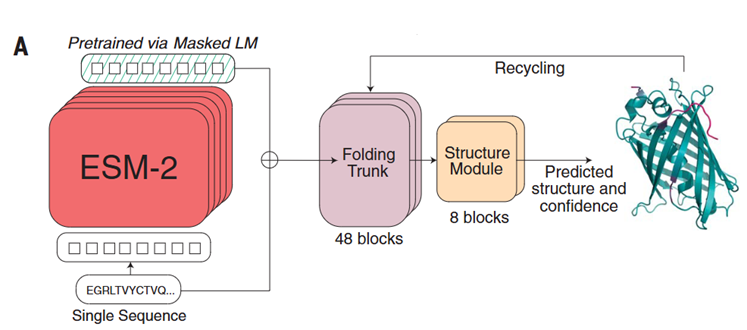

ESM2 모델을 불러오고, 임베딩을 얻기 위해 추론 모드로 전환하겠습니다.

ESM-2 모델 esm2_t33_650M_UR50D()는 33 layer Transformer이며, 650M개의 파라미터를 가지고 있습니다.

- `model` : ESM-2 모델을 의미합니다.
- `alphabet` : 단백질의 아미노산 서열을 토큰으로 변환하는 기능을 수행합니다.

In [ ]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model = model.to(device)
model.eval()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t33_650M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

ESM-2는 Transformer 기반 모델로 embed_tokens, layers, contact_head, emb_layer_norm_after, lm_head로 구성됩니다.

- `embed_tokens` : 입력 토큰을 1280차원 벡터로 변환하는 embedding layer입니다.
- `layers` : 총 33개의 Transformer 인코더 블록으로 구성되며, 각 블록은 Self-Attention과 Feedforward Network를 포함합니다.
- `contact_head` : 단백질 구조(접촉) 예측을 위한 추가적인 head입니다.
- `emb_layer_norm_after` : 최종 임베딩 출력을 정규화하는 layer입니다.
- `lm_head` : RoBERTa 스타일의 언어 모델 head로, 단백질 서열을 예측하는 역할을 합니다.

In [ ]:
print(alphabet.all_toks)

['<cls>', '<pad>', '<eos>', '<unk>', 'L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', 'X', 'B', 'U', 'Z', 'O', '.', '-', '<null_1>', '<mask>']


ESM-2 모델에서 사용하는 모든 token들은 위와 같습니다.
- 20가지 필수 아미노산이 포함되어 있습니다.
- `<cls>` : 시퀀스의 시작을 나타내며, 시퀀스 전체 임베딩을 추출할 때 사용합니다.
- `<eos>` : 시퀀스의 끝을 나타내며, 시퀀스 종료를 표시해줍니다.
- `<unk>` : 알려지지 않은 토큰을 처리할 때 사용합니다.
- `<pad>` : 패딩 토큰입니다. 주로 배치 내의 시퀀스 길이를 맞추기 위해 사용합니다.
- `<mask>` : 마스킹 토큰입니다. 훈련 중 일부 아미노산을 가리고 모델이 이를 예측하도록 합니다.
- `-` : 갭을 나타내며, ESM-MSA 모델에서 주로 쓰입니다.
- `X` : 불확실한 아미노산을 뜻합니다.

In [ ]:
batch_converter = alphabet.get_batch_converter()

`alphabet.get_batch_converter()`는 배치 데이터를 모델이 처리할 수 있도록 토큰화하고 텐서로 변환하는 함수를 반환합니다.

다시 말해, `batch_converter`를 실행하면, 서열을 토큰화하고 [CLS] 토큰과 [EOS] 토큰을 추가한 후 텐서 형태로 변환합니다.

이 과정은 ESM 모델을 사용할 때 필수적인 입력 데이터 변환 단계입니다.

##3. 시퀀스 데이터 불러오기

4번째 단계에서는 ESM-2를 통해 아미노산 시퀀스에 대한 임베딩을 얻을 예정입니다.

사용할 시퀀스는 TP53 단백질의 변이 시퀀스들입니다.

이 시퀀스들을 불러오도록 하겠습니다.

In [ ]:
variant_sequences = pd.read_csv("./data/ESM2/TP53_variant_sequences.csv")
variant_sequences.head()

,sequence,clinical_significance
0,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,Pathogenic
1,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,Pathogenic
2,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,Pathogenic
3,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,Pathogenic
4,MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLS...,Pathogenic


In [ ]:
print("variant sequence 데이터의 형태")
print(variant_sequences.shape)
print("아미노산 시퀀스의 길이")
print(variant_sequences['sequence'].apply(len).iloc[0])
print("시퀀스들의 clinical significance")
print(variant_sequences['clinical_significance'].unique())

variant sequence 데이터의 형태
(650, 2)
아미노산 시퀀스의 길이
393
시퀀스들의 clinical significance
['Pathogenic' 'Likely pathogenic' 'Benign' 'Likely benign']


이 데이터에는 393mer 길이의 650개의 변이 시퀀스들이 포함되어 있습니다.

각 TP53 variant 시퀀스들은 clinical significance 라벨을 가지며, 이는 변이가 발생했을 때의 임상적 의미를 나타냅니다.

- Pathogenic (병원성) : 질병을 유발하는 변이
- Likely pathogenic (병원성 가능성 있음) : 질병을 유발할 가능성이 높은 변이
- Likely benign (양성 가능성 있음) : 질병과 관련이 없을 가능성이 높은 변이
- Benign (양성) : 건강에 영향을 미치지 않는 변이

##4. ESM-2 임베딩 추출하기

이제 ESM-2를 통해 아미노산 시퀀스에 대한 임베딩을 얻어보겠습니다.

아래는 ESM2 모델을 사용하여 단백질 서열의 임베딩을 추출하는 함수입니다.


In [ ]:
def get_embedding(sequence: str, model, batch_converter, device=device):

    # 데이터 변환
    data = [("seq_label", sequence)]
    _, _, batch_tokens = batch_converter(data)

    gc.collect()
    torch.cuda.empty_cache()

    batch_tokens = batch_tokens.to(device, non_blocking=True)

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)
        token_representations = results["representations"][33]

        # <CLS> 제외하고 실제 시퀀스 길이만큼 반환
        embeddings = token_representations[0, 1: len(sequence) + 1].detach()

    del batch_tokens, results, token_representations
    gc.collect()
    torch.cuda.empty_cache()

    return embeddings  # (L, D) 형태의 텐서 반환

모델의 주요 동작 과정은 아래와 같습니다.

- `batch_converter(data)` : 서열을 토큰화한 후, 텐서로 변환합니다.
- `model(batch_tokens.cuda(), repr_layers=[33], return_contacts=False)` : 모델의 마지막 33번째 레이어에서 임베딩을 가지고 옵니다. 접촉 맵은 사용하지 않습니다.
- `token_representations[0, 1: len(sequence) + 1]` : [CLS] 토큰을 제외한 실제 서열 길이에 해당하는 토큰의 임베딩만을 저장합니다.

아래는 추출한 토큰 단위 임베딩에 mean pooling을 적용하여 시퀀스 단위의 임베딩을 생성하는 코드입니다.

In [ ]:
def mean_pooling(embeddings: torch.Tensor):

    return embeddings.mean(dim=0).cpu().numpy()  # (D,) 형태 반환

한 개 변이에 대한 시퀀스 단위 임베딩만 우선 생성해보겠습니다.


In [ ]:
variant_embedding = get_embedding(variant_sequences['sequence'][0], model, batch_converter)
variant_mean_embedding = mean_pooling(variant_embedding)

print("토큰 단위 임베딩")
print(variant_embedding.shape)  # (L, D)
print("시퀀스 단위 임베딩")
print(variant_mean_embedding.shape)  # (D,)

토큰 단위 임베딩
torch.Size([393, 1280])
시퀀스 단위 임베딩
(1280,)


위의 출력 결과와 같이, 각 아미노산(총 393개)에 대해 1280차원의 임베딩이 먼저 생성되었고 mean pooling을 통해 이를 시퀀스 단위로 합쳤다는 것을 확인할 수 있습니다.

이어서 650개 모든 변이 시퀀스들에 대한 임베딩을 한 번에 추출해보겠습니다.

**아래 빈 칸을 채워 함수를 실행해주세요.**

In [ ]:
# 결과 저장 리스트
all_embeddings = []

# 모든 sequence에 대해 embedding 추출 및 mean pooling 적용
for seq in tqdm(variant_sequences["sequence"], desc="Processing sequences"):
    embedding = get_embedding(seq, model, batch_converter)
    mean_embedding = mean_pooling(embedding)
    all_embeddings.append(mean_embedding)

# 리스트를 numpy 배열로 변환
all_embeddings = np.array(all_embeddings)

# 결과 확인
print("Final embeddings shape:", all_embeddings.shape)  # (N, D)

Processing sequences:   0%|          | 0/650 [00:00<?, ?it/s]

Final embeddings shape: (650, 1280)


위와 같이 650개의 서열마다 1280 차원의 임베딩이 생성되었습니다.

##5. ESM-2 임베딩 시각화하기

이제 각 임베딩들이 잘 만들어졌는지, 시각화해보겠습니다.

아래 코드는 t-SNE (t-Distributed Stochastic Neighbor Embedding) 기법을 사용하여 고차원 단백질 서열 임베딩을 2D로 변환하고 시각화하는 과정입니다.

이를 통해 서로 다른 변이 유형이 어떻게 분포하는 시각적으로 분석할 수 있습니다.

t-SNE의 주요 하이퍼파라미터에는 perplexity, learning_rate, max_iter 등이 있습니다.
- `perplexity `: 점 간의 거리(유사도)를 측정하는 기준 값입니다. 작을 수록 지역적인 구조를, 높을 수록 전체적인 구조를 잘 반영합니다.
- `learning_rate` : 점을 배치하는 속도를 조절하는 값입니다.
- `max_iter` : 최적의 위치를 찾을 때까지 업데이트를 반복하는 최대 반복 횟수입니다.

하이퍼파라미터를 직접 조정하면서 다양한 플롯을 비교해보세요!

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


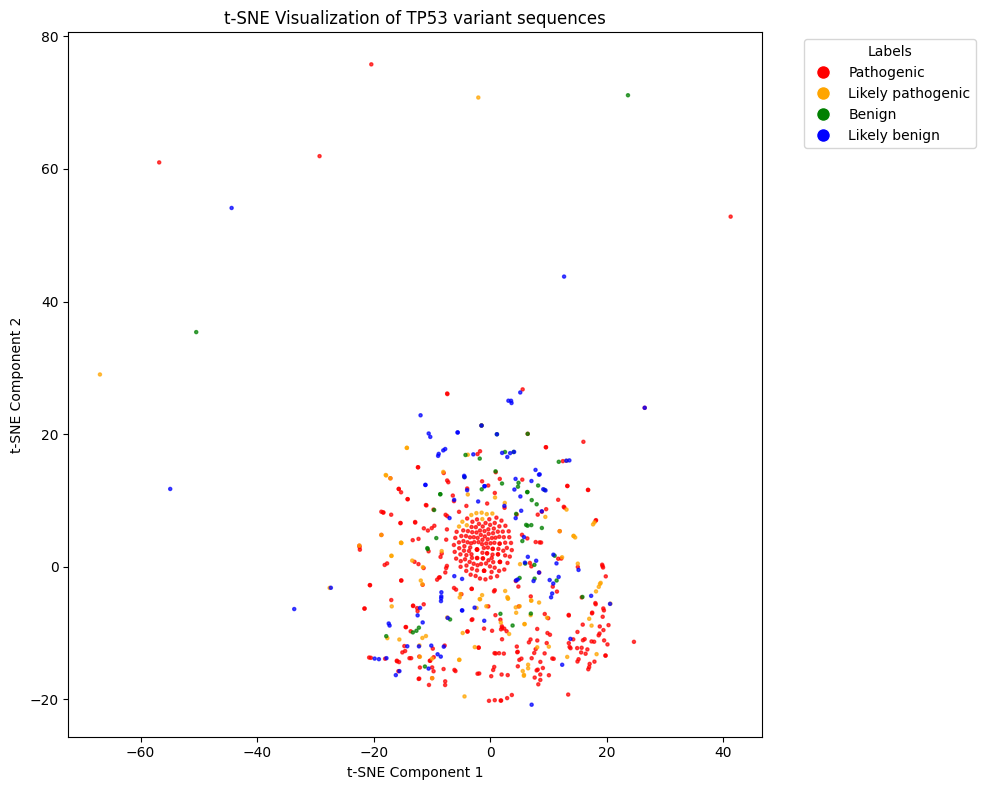

In [ ]:
# clinical significance 정보를 label로 설정
labels = list(variant_sequences['clinical_significance'])

# 3D 임베딩 배열을 2D로 변환 (이미 2D라면 생략 가능)
if len(all_embeddings.shape) == 3:  # (N, L, D) 형태라면 펼침
    all_embeddings_flat = all_embeddings.reshape(all_embeddings.shape[0], -1)
else:  # 이미 (N, D) 형태라면 그대로 사용
    all_embeddings_flat = all_embeddings

# t-SNE 하이퍼파라미터
perplexity = 50
learning_rate = 200
max_iter = 700

# 레이블별 색상 설정
label_to_color = {
    'Pathogenic': 'red',
    'Likely pathogenic' : 'orange',
    'Benign': 'green',
    'Likely benign': 'blue'
}

# t-SNE 실행
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=max_iter, random_state=42)
tsne_results = tsne.fit_transform(all_embeddings_flat)

# 시각화
plt.figure(figsize=(10, 8))

# 모든 포인트를 레이블별 색상으로 표시
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                      c=[label_to_color.get(label, 'gray') for label in labels],  # 알 수 없는 라벨은 'gray'
                      s=5, alpha=0.7)

# 범례 생성
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                       markerfacecolor=color, markersize=10)
           for label, color in label_to_color.items()]

plt.legend(handles=handles, title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Visualization of TP53 variant sequences")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

t-SNE로 시각화한 결과입니다.해석해보도록 하겠습니다.

Pathogenic 변이 시퀀스들이 밀집된 클러스터를 형성하고 있음을 확인할 수 있습니다.

이러한 분포는 ESM-2 모델의 임베딩이 아미노산 변이 정보를 효과적으로 반영하고 있음을 시사합니다.

즉, 모델이 Pathogenic과 Benign 시퀀스를 구별할 수 있는 특징을 잘 학습했음을 확인할 수 있습니다.

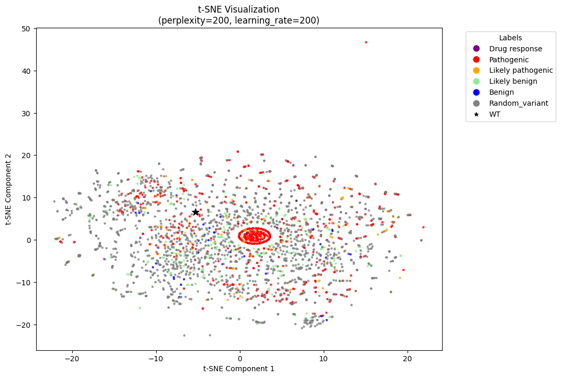

위의 플롯은 실습 데이터보다 더 많은 데이터를 사용하여 임베딩을 생성하고 시각화한 결과입니다.
Pathogenic 시퀀스와 일부 Likely pathogenic 시퀀스가 보다 뚜렷한 클러스터를 형성하고 있습니다. 반면, Wild type 시퀀스 (변이가 없는 시퀀스)는 이 클러스터에서 상대적으로 먼 위치에 매핑되어 있습니다.
이를 통해 ESM-2의 임베딩이 아미노산 변이 정보를 효과적으로 반영하고 있음을 알 수 있습니다.

##6. UniProt에서 단백질 시퀀스를 불러와 임베딩 추출, 시각화하기

지금까지 실습한 내용들을 바탕으로, UniProt 단백질 시퀀스에 대한 임베딩을 추출하는 과정입니다.

다음의 단백질 리스트에서 원하는 단백질들을 골라 실습해 보시길 바랍니다.

**단백질 리스트**
- `혈액 관련 단백질`: hemoglobin, albumin
- `근육 관련` : myoglobin, actin
- `호르몬`: insulin, Oxytocin
- `결합 조직 단백질`: collagen, keratin
- `유전자 조절 단백질` : p53, EGFR


위의 코드들을 참고하여 직접 코드를 작성해보세요.

<font color='45A07A'>## 코드를 직접 작성해주세요 ##</font> 는 여러분이 직접 작성해야 하는 부분입니다!



아래 코드는 UniProt에서 특정 단백질 이름으로 단백질 서열을 가져오는 함수입니다.

In [ ]:
import requests

def fetch_uniprot_sequences(protein_names, max_results):

    if isinstance(protein_names, str):
        protein_names = [protein_names]

    all_sequences = {}

    for protein_name in protein_names:
        base_url = "https://rest.uniprot.org/uniprotkb/search"
        params = {
            "query": protein_name,  # 단백질 이름 검색
            "format": "fasta",      # FASTA 형식으로 가져오기
            "size": max_results     # 최대 가져올 개수
        }

        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            fasta_data = response.text
            sequences = {}
            current_id = None

            for line in fasta_data.split("\n"):
                if line.startswith(">"):
                    current_id = line.split("|")[1]  # UniProt ID 가져오기
                    sequences[current_id] = ""
                elif current_id:
                    sequences[current_id] += line.strip()  # 서열 추가

            all_sequences[protein_name] = sequences
        else:
            print(f"Error {response.status_code}: '{protein_name}' 데이터 검색 실패")

    return all_sequences

`protein_name`에 원하는 단백질의 이름을 넣어 해당 단백질들의 아미노산 시퀀스를 불러오세요.

**두 개 이상의 단백질을 넣어주세요!**

In [ ]:
# 사용 예시
protein_names = ["hemoglobin", "myoglobin", "insulin", "p53", "EGFR"]

#protein_names
sequences = fetch_uniprot_sequences(protein_names, max_results=20)

# 결과 출력
MAX_DISPLAY = 3  # 출력할 최대 서열 개수

if sequences:
    for protein, seq_dict in sequences.items():
        total_seqs = len(seq_dict)  # 전체 서열 개수
        print(f"\n **{protein}** 단백질의 UniProt 서열들 (총 {total_seqs}개 중 {MAX_DISPLAY}개만 표시):")

        for i, (uniprot_id, seq) in enumerate(seq_dict.items()):
            if i >= MAX_DISPLAY:  # 최대 3개까지만 출력
                break
            print(f"> {uniprot_id}\n{seq}\n")

        if total_seqs > MAX_DISPLAY:
            print(f"... (총 {total_seqs}개 서열 중 일부만 표시됨)\n")


 **hemoglobin** 단백질의 UniProt 서열들 (총 20개 중 3개만 표시):
> P68871
MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH

> P02042
MVHLTPEEKTAVNALWGKVNVDAVGGEALGRLLVVYPWTQRFFESFGDLSSPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFSQLSELHCDKLHVDPENFRLLGNVLVCVLARNFGKEFTPQMQAAYQKVVAGVANALAHKYH

> P02100
MVHFTAEEKAAVTSLWSKMNVEEAGGEALGRLLVVYPWTQRFFDSFGNLSSPSAILGNPKVKAHGKKVLTSFGDAIKNMDNLKPAFAKLSELHCDKLHVDPENFKLLGNVMVIILATHFGKEFTPEVQAAWQKLVSAVAIALAHKYH

... (총 20개 서열 중 일부만 표시됨)


 **myoglobin** 단백질의 UniProt 서열들 (총 20개 중 3개만 표시):
> P02144
MGLSDGEWQLVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAEIKPLAQSHATKHKIPVKYLEFISECIIQVLQSKHPGDFGADAQGAMNKALELFRKDMASNYKELGFQG

> P02192
MGLSDGEWQLVLNAWGKVEADVAGHGQEVLIRLFTGHPETLEKFDKFKHLKTEAEMKASEDLKKHGNTVLTALGGILKKKGHHEAEVKHLAESHANKHKIPVKYLEFISDAIIHVLHAKHPSDFGADAQAAMSKALELFRNDMAAQYKVLGFHG

> P04247
MGLSDGEWQLVLNVWGKVEADLAGHGQEVLIGLFKTHPETLDKFDKFKNLKSEEDMKG

아래는 위에서 사용했던 임베딩 추출 및 mean pooling 함수입니다.

빈 칸을 채워주시면 됩니다.

In [ ]:
def get_embedding(sequence: str, model, batch_converter, device=device):

    # 데이터 변환
    data = [("seq_label", sequence)]
    _, _, batch_tokens = batch_converter(data)

    gc.collect()
    torch.cuda.empty_cache()

    batch_tokens = batch_tokens.to(device, non_blocking=True)

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=False)
        token_representations = results["representations"][33]

        # <CLS> 제외하고 실제 시퀀스 길이만큼 반환
        embeddings = token_representations[0, 1: len(sequence) + 1].detach()

    del batch_tokens, results, token_representations
    gc.collect()
    torch.cuda.empty_cache()

    return embeddings  # (L, D) 형태의 텐서 반환

In [ ]:
def mean_pooling(embeddings: torch.Tensor):

    return embeddings.mean(dim=0).cpu().numpy()  # (D,) 형태 반환

아래는 위의 함수들을 사용하여 UniProt에서 가져온 단백질 시퀀스에 대한 임베딩을 추출하는 코드입니다.

In [ ]:
all_embeddings = []
all_labels = []

for protein, seq_dict in tqdm(sequences.items(), desc="Processing sequences"):
    for uniprot_id, seq in seq_dict.items():
        embedding = get_embedding(seq, model, batch_converter)
        mean_embedding = mean_pooling(embedding)
        all_embeddings.append(mean_embedding)
        all_labels.append(protein)  # 단백질 이름을 라벨로 저장

all_embeddings = np.array(all_embeddings)

Processing sequences:   0%|          | 0/5 [00:00<?, ?it/s]

단백질의 임베딩들이 잘 생성되었는지 아래 코드를 출력하여 확인해보세요.

In [ ]:
all_embeddings.shape

(100, 1280)

이제 단백질 임베딩들을 시각화해보도록 하겠습니다.

아래 코드는 t-SNE (t-Distributed Stochastic Neighbor Embedding) 기법을 사용하여 고차원 단백질 서열 임베딩을 2D로 변환하고 시각화하는 과정입니다.

이를 통해 서로 다른 단백질들이 어떻게 분포하는지 시각적으로 분석할 수 있습니다.

마찬가지로 빈 칸을 채워주시면 됩니다.

t-SNE의 주요 하이퍼파라미터에는 perplexity, learning_rate, max_iter 등이 있습니다.
- `perplexity `: 점 간의 거리(유사도)를 측정하는 기준 값입니다. 작을수록 지역적인 구조를, 높을수록 전체적인 구조를 잘 반영합니다.
- `learning_rate` : 점을 배치하는 속도를 조절하는 값입니다.
- `max_iter` : 최적의 위치를 찾을 때까지 업데이트를 반복하는 최대 반복 횟수입니다.

하이퍼파라미터도 직접 조정해보시길 바랍니다.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


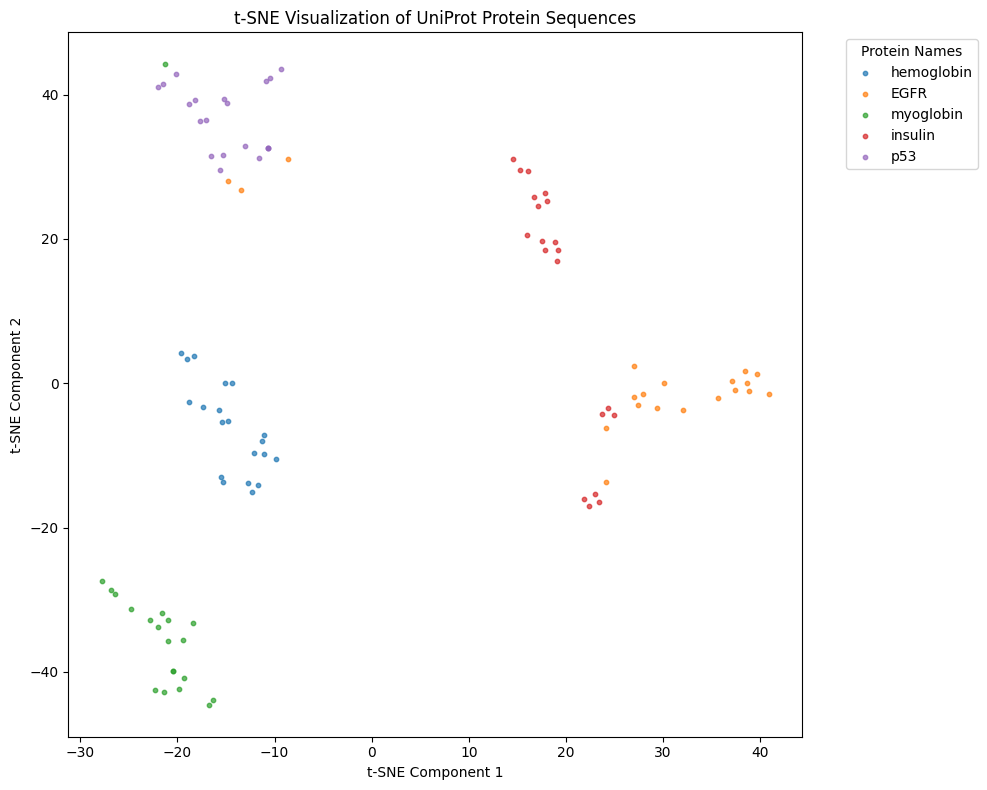

In [ ]:
# t-SNE 실행을 위한 데이터 변환
if len(all_embeddings.shape) == 3:
    all_embeddings_flat = all_embeddings.reshape(all_embeddings.shape[0], -1)
else:
    all_embeddings_flat = all_embeddings

# t-SNE 하이퍼파라미터 설정
perplexity = 5
learning_rate = 100
max_iter = 700

# t-SNE 실행
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=max_iter, random_state=42)
tsne_results = tsne.fit_transform(all_embeddings_flat)

# 단백질마다 자동 색상 할당
unique_labels = list(set(all_labels))  # 고유한 단백질 라벨 리스트
color_palette = sns.color_palette("tab10", len(unique_labels))  # 자동으로 색상 생성
label_to_color = {label: color for label, color in zip(unique_labels, color_palette)}

plt.figure(figsize=(10, 8))

for protein in unique_labels:
    indices = [i for i, label in enumerate(all_labels) if label == protein]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1],
                c=[label_to_color[protein]], label=protein, s=10, alpha=0.7)

# 범례 및 그래프 설정
plt.legend(title="Protein Names", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("t-SNE Visualization of UniProt Protein Sequences")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.tight_layout()
plt.show()

각 단백질 별 시퀀스 임베딩들이 클러스터를 형성하고 있는지,

유사한 생물학적 기능을 가지는 단백질들이 임베딩이 서로 가까이 위치하고 있는지 t-SNE 플롯을 통해 분석해 보시길 바랍니다.

ESM-2 모델의 실습은 여기까지입니다.

이로써 **Advanced Deep Learning Models for Biomedical Research** 1교시 실습을 마치겠습니다.

고생하셨습니다. 감사합니다!